In [126]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [127]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [128]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [129]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [130]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [131]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [132]:
# Save references to each table
station = Base.classes.station

In [133]:
measurement = Base.classes.measurement

In [134]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [135]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [136]:
#Creating a Function to calculate from a query and get a Data frame as output

def past12months (table, column1=None, column2=None, QUERY=None):
    
    
    # Find the most recent date in the data set.
    results_date=session.query(table.date).order_by(table.date.desc()).first()
    most_recent_date = results_date[0]
    # converting the string date into datime
    most_recent_date_time = datetime.strptime(most_recent_date, '%Y-%m-%d')


    # Calculate the date one year from the last date in data set.
    # substracting 365 days (12 months) out of the most recent year
    year_before = most_recent_date_time - timedelta(days = 365 )
    
    # Query to retrieve the data and precipitation scores
    precip_back12moths_query = QUERY
    
    
    # Saving into data frame depending if is fefined one or two columns...adding some value error
    # just to make sure there are insert
    if column1 and column2:
        year_back_df = pd.DataFrame(precip_back12moths_query, columns=[column1, column2])
    elif column1:
        year_back_df = pd.DataFrame(precip_back12moths_query, columns=[column1])
    else:
        raise ValueError("! At least one column must be specified !")

        
    return year_back_df




In [137]:
 query = session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).\
            filter(measurement.date>=year_before).all()

In [138]:
dates_precipitation_df = past12months(measurement,"Dates","Precipitation",
                                     QUERY=query)
dates_precipitation_df

,Dates,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


In [139]:
# Sort the dataframe by date
df2 = dates_precipitation_df.sort_values(by="Dates")
df2

,Dates,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2221,2017-08-23,0.08
2219,2017-08-23,0.00
2220,2017-08-23,0.00


In [140]:
# Use Pandas Plotting with Matplotlib to plot the data
#(just practicing functions, is redundant in this case because is just like using .plot())
def ploting(DF,X = None, Y = None ,KIND=None ,TITLE = None , YLABEL = None, XLABEL = None, BINS=None):

#     DF.plot(x=X,
#             y=Y,
#             kind=KIND,
#             title=TITLE,
#             ylabel=YLABEL,
#             xlabel=XLABEL,
#             bins=BINS)
#     plt.xticks(rotation=45)
    
    
        if KIND == "hist":
            DF.plot.hist(x=X, y=Y, bins=BINS)
            plt.title(TITLE)
            plt.xlabel(XLABEL)
            plt.xticks(rotation=45)
        else:
            DF.plot(x=X, y=Y, kind=KIND)
            plt.title(TITLE)
            plt.ylabel(YLABEL)
            plt.xlabel(XLABEL)
            plt.xticks(rotation=45)

            plt.show()

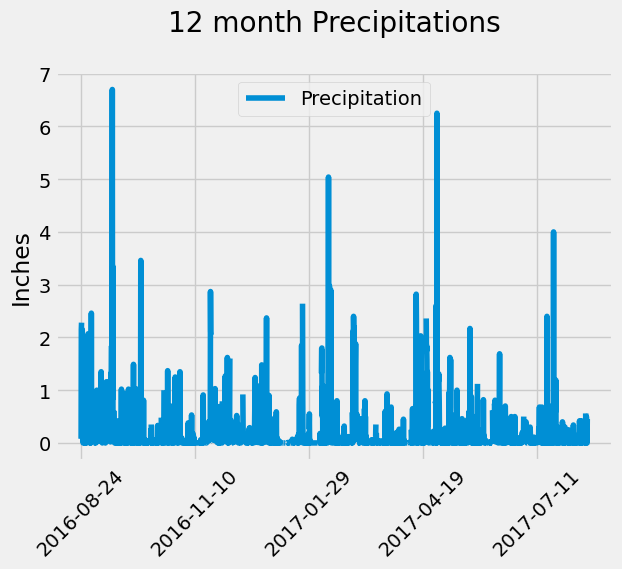

In [141]:
precip = ploting(df2,X = "Dates", Y = "Precipitation",KIND="line" ,TITLE = "12 month Precipitations\n", YLABEL = "Inches")
precip

In [142]:
# Use Pandas to calculate the summary statistics for the precipitation data

df2.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [143]:
#inspecting Columns names and type of data

columns1 = inspector.get_columns("station")
for c in columns1:
    print(c["name"], c["type"])



id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [144]:
# Design a query to calculate the total number of stations in the dataset
total_stations =session.query(func.count()).select_from(station).scalar()

# print(total_stations)
total_stations

9

In [145]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station,func.count(measurement.station)).\
                               group_by(measurement.station).\
                               order_by(func.count(measurement.station).desc()).all()


most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

    Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [146]:
most_active_stations1 = session.query(func.min(measurement.tobs),
                                      func.max(measurement.tobs),
                                      func.avg(measurement.tobs)).\
                filter(measurement.station == 'USC00519281').\
                        order_by(func.min(measurement.tobs)).all()

most_active_stations1

[(54.0, 85.0, 71.66378066378067)]

    Using the most active station id
    Query the last 12 months of temperature observation data for this station and plot the
    results as a histogram


In [147]:
query2 = session.query(measurement.tobs).\
      filter(measurement.date >= year_before, measurement.station == 'USC00519281').\
      order_by(measurement.tobs).all()

In [148]:
df3 = past12months(measurement,"Tobs",QUERY=query2)
df3

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0
...,...
346,81.0
347,82.0
348,82.0
349,82.0


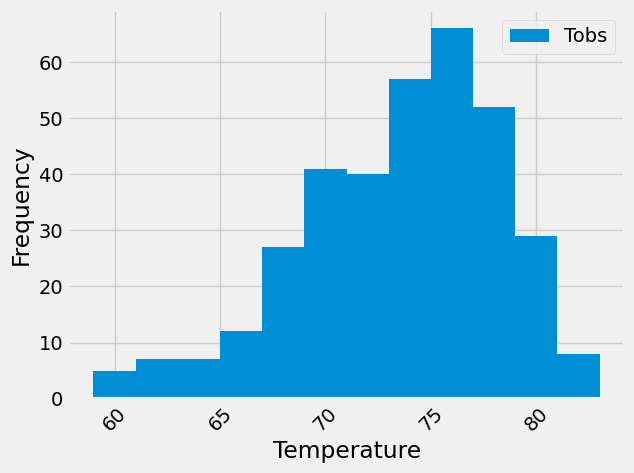

In [149]:
ploting(df3,KIND="hist",XLABEL="Temperature",BINS=12)

# Close Session

In [150]:
# Close Session
session.close()